In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import sys

import librosa
import librosa.display

from sklearn.preprocessing import OneHotEncoder

from IPython.display import Audio
import noisereduce as nr

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pickle as pkl
import multiprocessing as mp
from numba import jit

In [2]:
def load_data(path, columns_to_drop=['hash_id', 'source_id']):
    df = pd.read_json(path, lines=True).drop(columns=columns_to_drop)
    df['audio_path'] = df['audio_path'].apply(lambda x: x[5:])
    df = df[df['annotator_emo'] != 'other']
    #df = df[df['duration'] <= 5.0]
    return df

In [3]:
crowd_train = load_data(r'D:\data\dusha\crowd\crowd_train\raw_crowd_train.jsonl')
crowd_test = load_data(r'D:\data\dusha\crowd\crowd_test\raw_crowd_test.jsonl')
podcast_train = load_data(r'D:\data\dusha\podcast\podcast_train\raw_podcast_train.jsonl')
podcast_test = load_data(r'D:\data\dusha\podcast\podcast_test\raw_podcast_test.jsonl')

In [4]:
crowd_train.head()

,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo
0,475e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry
1,2f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral
2,9937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,None,None
3,fb0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral
4,196dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral


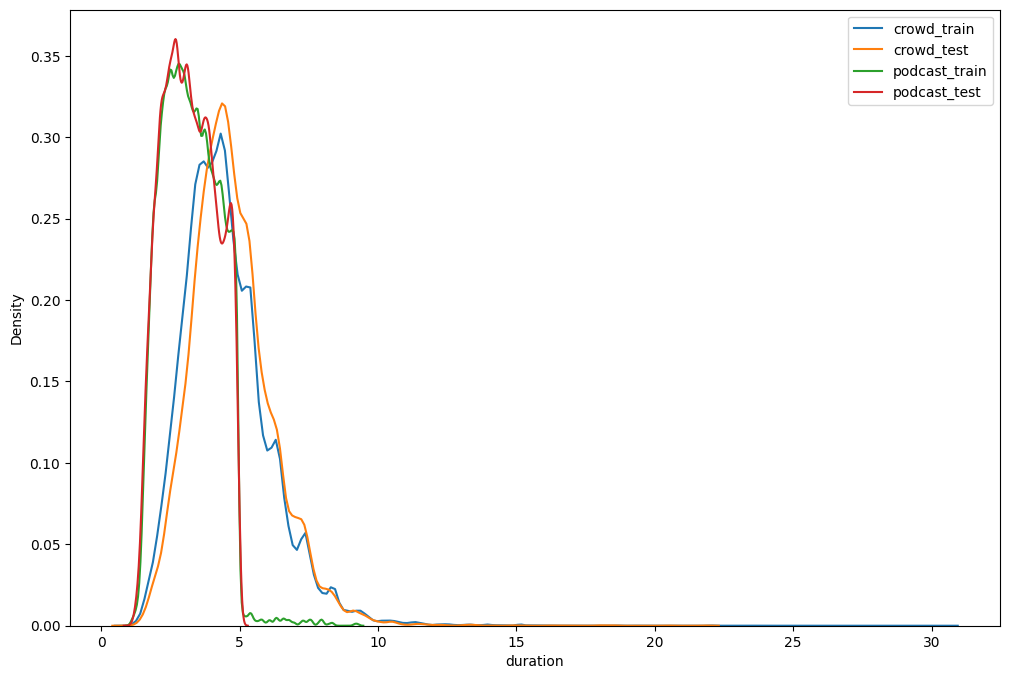

In [5]:
plt.figure(figsize=(12, 8))
sns.distplot(crowd_train['duration'], label='crowd_train', hist=False)
sns.distplot(crowd_test['duration'], label='crowd_test', hist=False)
sns.distplot(podcast_train['duration'], label='podcast_train', hist=False)
sns.distplot(podcast_test['duration'], label='podcast_test', hist=False)
plt.legend()

Посмотрите на баланс классов

<Axes: >

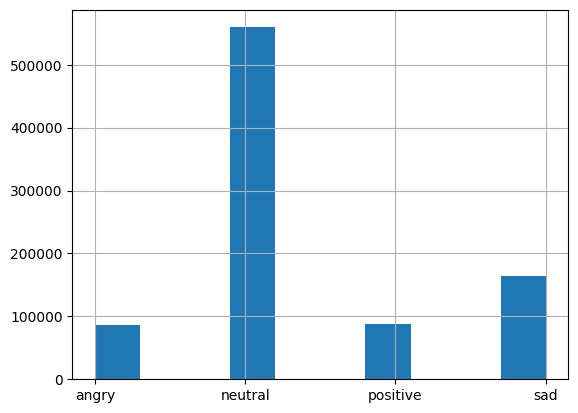

In [6]:
crowd_train['annotator_emo'].hist()

<Axes: >

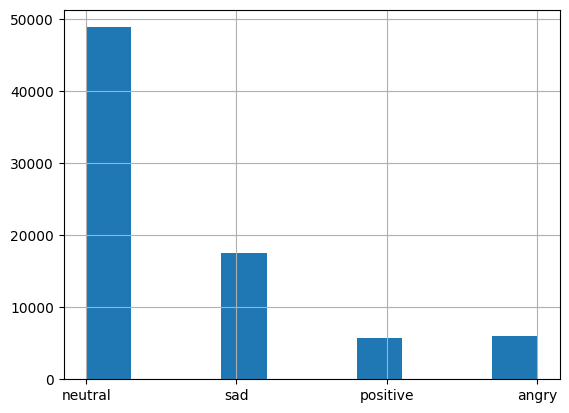

In [7]:
crowd_test['annotator_emo'].hist()

<Axes: >

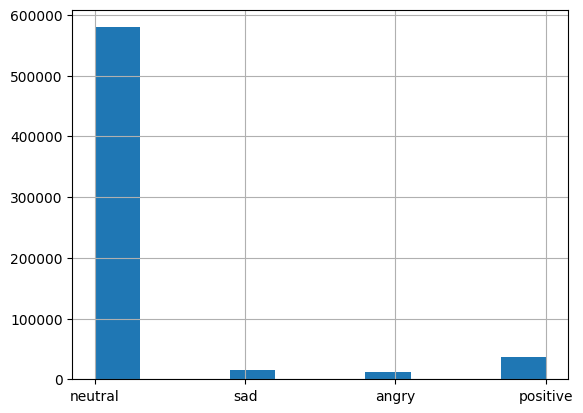

In [8]:
podcast_train['annotator_emo'].hist()

<Axes: >

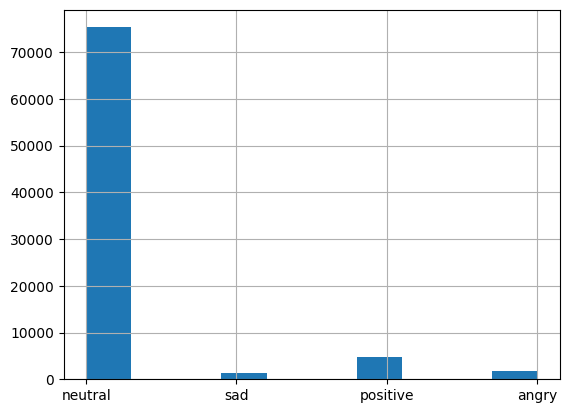

In [9]:
podcast_test['annotator_emo'].hist()

Посмотрите содержимое каждого из классов и выведите график "Mean MFCC на Podcast, без предобработки" по всем классам

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar()

def create_mfcc(data, sr):
    plt.figure(figsize=(11, 3))
    mfcc = librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()
    plt.show()
    mfcc = (np.mean(mfcc, axis=1))
    plt.plot(mfcc)
    plt.show()
    return mfcc

In [11]:
path_type = {
    'crowd_train': r'D:\data\dusha\crowd\crowd_train\wavs',
    'crowd_test': r'D:\data\dusha\crowd\crowd_test\wavs',
    'podcast_train': r'D:\data\dusha\podcast\podcast_train\wavs',
    'podcast_test': r'D:\data\dusha\podcast\podcast_test\wavs'
    }

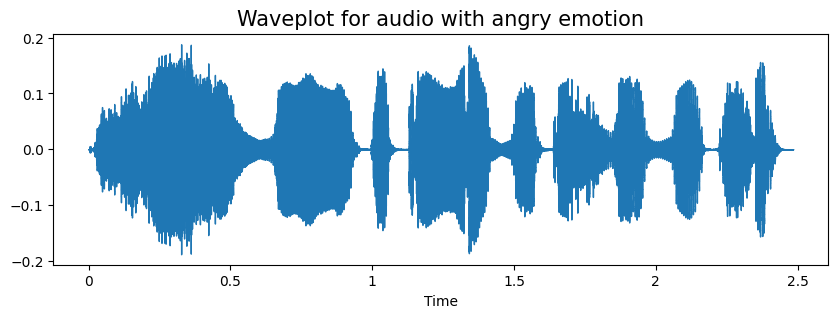

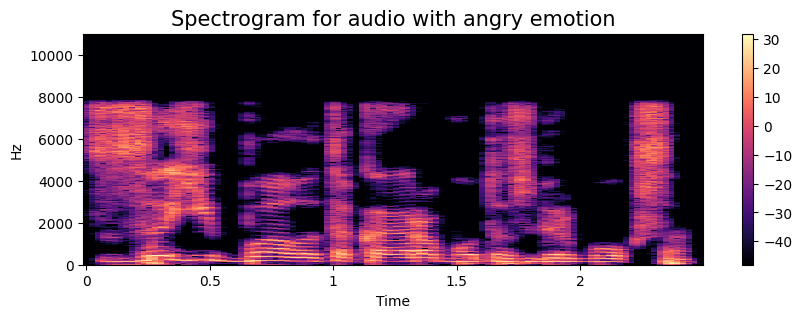

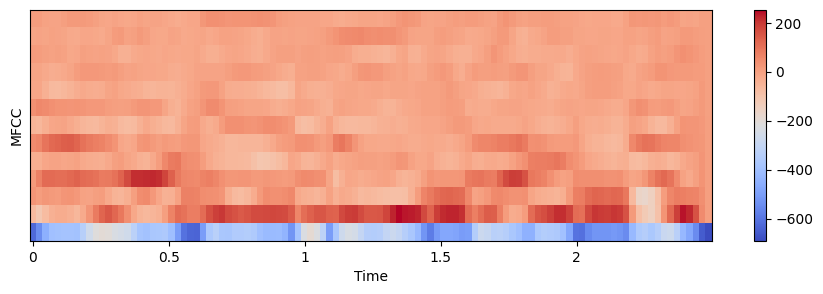

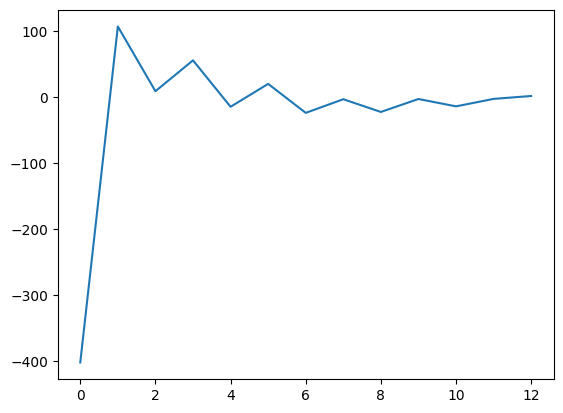

In [12]:
emo = 'angry'
path = path_type['crowd_train'] + '\\' + podcast_train[podcast_train['annotator_emo'] == emo]['audio_path'].iloc[3]
data, sr = librosa.load(path)
data = nr.reduce_noise(data, sr=sr)
xt, index = librosa.effects.trim(data, top_db=33)
display(Audio(xt, rate=sr))
create_waveplot(xt, sr, emo)
create_spectrogram(xt, sr, emo)
mfcc_p = create_mfcc(xt, sr)

Аналогично для других классов

Вывод графика

Text(0.5, 1.0, 'Mean MFCC на Crowd, после предобработки')

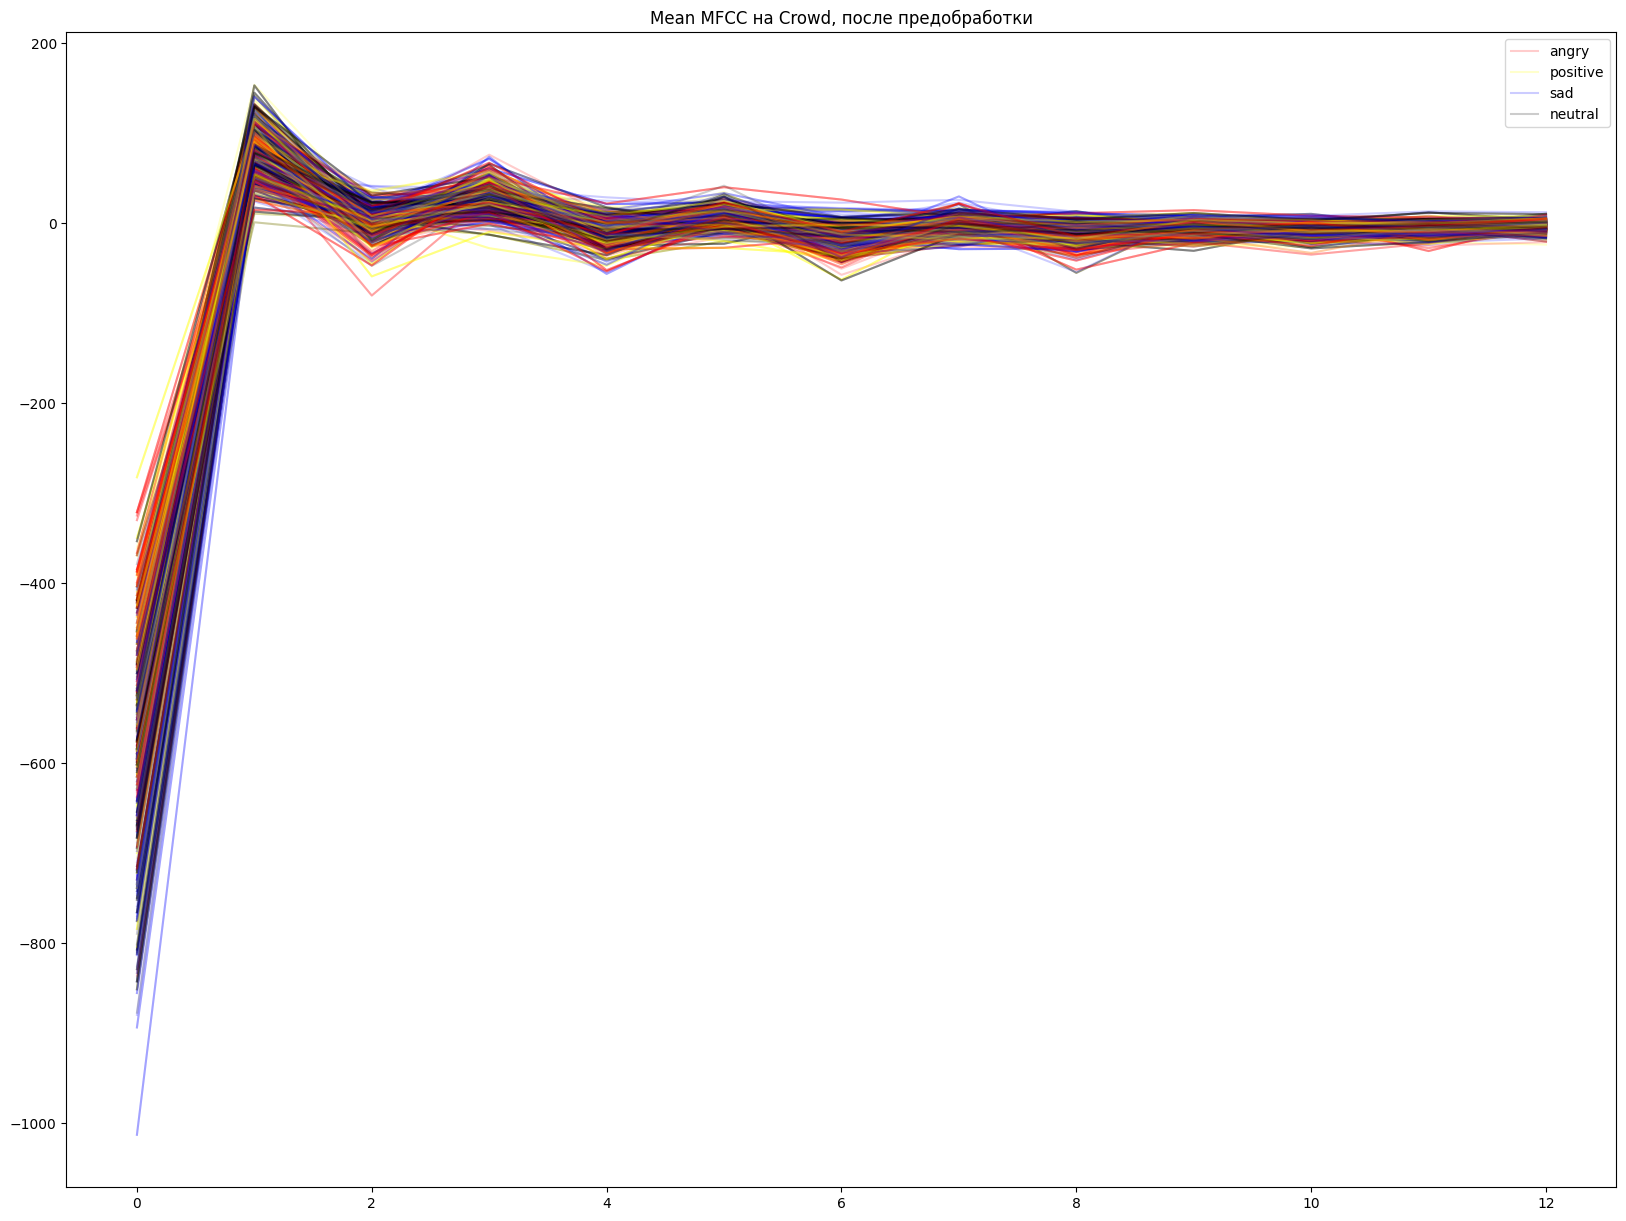

In [13]:
plt.figure(figsize=(20, 15))
colors = ['', 'black', 'yellow', 'blue', '', 'red']
for i in range(200):
    for emo in ['angry', 'positive', 'sad', 'neutral']:
        path = path_type['crowd_train'] + '\\' + crowd_train[crowd_train['annotator_emo'] == emo]['audio_path'].iloc[i]
        data, sr = librosa.load(path)
        data = nr.reduce_noise(data, sr=sr)
        data, index = librosa.effects.trim(data, top_db=33)
        mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13), axis=1)
        if i==0:
            mfcc2 = librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13)
            plt.plot(mfcc, color=colors[len(emo)%6], alpha=0.2, label=emo)
        else:
            plt.plot(mfcc, color=colors[len(emo)%6], alpha=0.2)
plt.legend()
plt.title('Mean MFCC на Crowd, после предобработки')